# Project: Investigate TMDb Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> I am investigating the TMBd Movie dataset. This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue. The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.


### Question(s) for Analysis
> 1. Which Year Has The Highest Profit Rate?
> 2. How are the average budget and revenue trends over the years?
> 3. What's the effect of movie runtime on its revenue and popularity?
> 4. Which genres are most popular from year to year?
> 5. Which properties influence high movie profits?

In [1]:
import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ray
ray.init()
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

> Getting a summary of the dataset, checking for null values and the datatypes for each column.

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
Mov_df = pd.read_csv('tmdb-movies.csv')

#print summary of the dataset
Mov_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

> Producing a descriptive summary of the dataset(For columns within numerical values)

In [3]:
# print descriptive summary of the dataset
Mov_df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [4]:
# Count total rows with null values in each column
Mov_df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [5]:
# Fill the null values with zero.
# Some rows contain string values, I opt not to update with zero

Mov_df.fillna(0)
Mov_df.shape

(10866, 21)


### Data Cleaning

#### Checking for duplicates in the dataframe and dropping them.
> This is to get accurate counts of the data entries

In [6]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

#Count the duplicate elements sum of all the rows
print(sum(Mov_df.duplicated()))

#Dropping duplicated rows
Mov_df.drop_duplicates(inplace=True)
Mov_df.shape

1


(10865, 21)

#### Change date format for 'release_date' column
> Aids in plotting timeseries data

In [7]:
# changing the 'release_date' to datetime format from string format
Mov_df['release_date'] = pd.to_datetime(Mov_df['release_date'])
Mov_df['release_date'].head()

0   2015-06-09
1   2015-05-13
2   2015-03-18
3   2015-12-15
4   2015-04-01
Name: release_date, dtype: datetime64[ns]

#### Dropping columns that arent needed in the analysis.
> To reduce on system resources consumption during analysis

In [8]:
Mov_df.drop(['overview','imdb_id','homepage','tagline'],axis =1,inplace = True)
Mov_df.shape

(10865, 17)

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: Which Year Has The Highest Profit Rate?

In [9]:
# calculate profit for each movie
# And add a new 'profit' and 'profit_adj' columns to the dataframe

Mov_df['profit'] = Mov_df['revenue'] - Mov_df['budget']
Mov_df['profit_adj'] = Mov_df['revenue_adj'] - Mov_df['budget_adj']

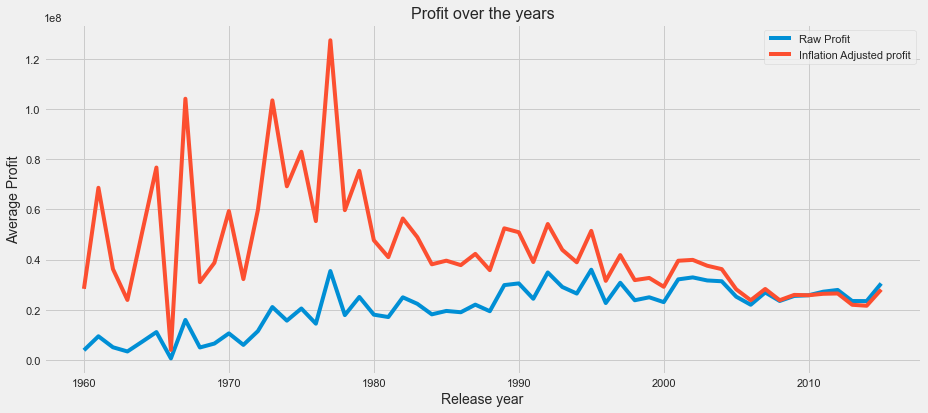

In [20]:
# Plot style
plt.style.use('fivethirtyeight')

# Get year-wise profit analysis by movies, its mean.
# Group the data accordi ng to realese_year, find its mean profit and plot 
Mov_df.groupby('release_year')['profit'].mean().plot(label = 'Raw Profit', legend = True)

# taking inflation into account
# What is the outlook of the profits?
Mov_df.groupby('release_year')['profit_adj'].mean().plot(label = 'Inflation Adjusted profit', legend = True)

# figure size
sns.set(rc={'figure.figsize':(20,10)})

# Plot title and labels.
plt.title("Profit over the years",fontsize = 16)
plt.xlabel('Release year',fontsize = 14)
plt.ylabel('Average Profit',fontsize = 14);

#### Overally the profits realised have been increasing over the years
##### It can be seen that 02-03 have the highest cumulative avarage profits.
> It can also be noted that between 1960-70 are the years when the profits were low.

#### Bringing inflation into the picture, the profits are decreasing.
> With inflation adjustment, 1970-1980 are years withn the highest proifts.

### Research Question 2: How are the average budget and revenue trends over the years?

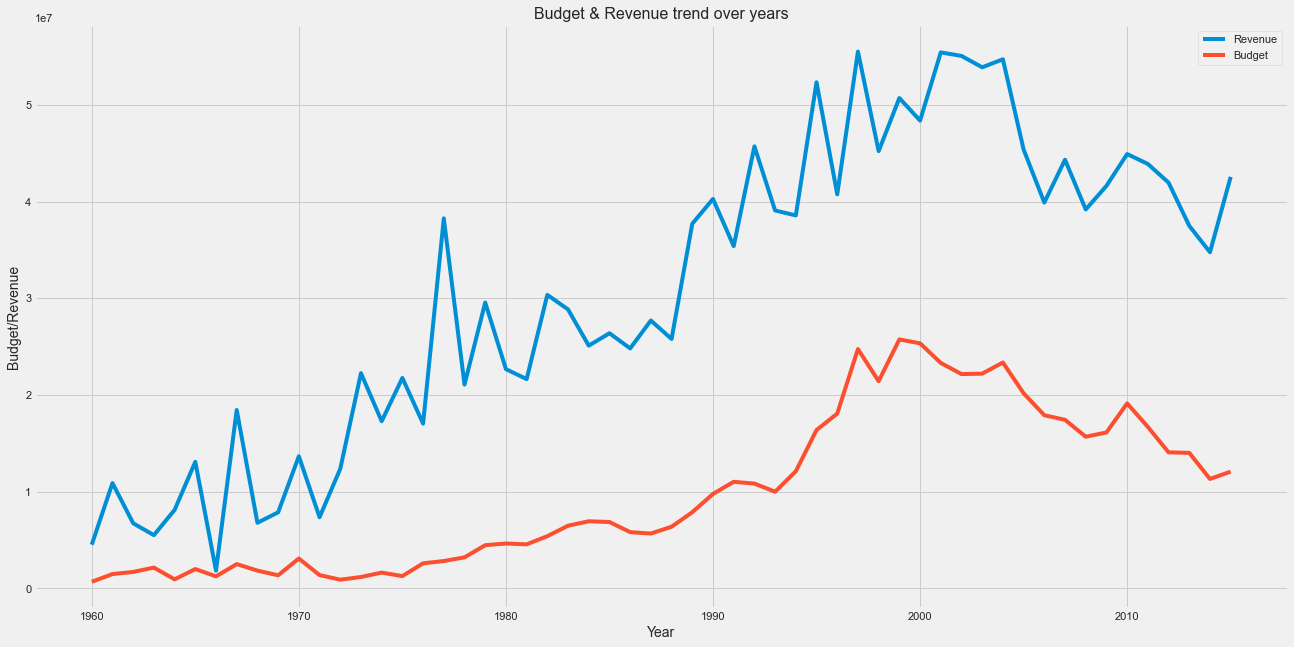

In [11]:

plt.style.use('fivethirtyeight')
Mov_df.groupby('release_year').mean()['revenue'].plot(label = 'Revenue', legend = True)
Mov_df.groupby('release_year').mean()['budget'].plot(label = 'Budget', legend = True)
# plot title
plt.title("Budget & Revenue trend over years",fontsize = 16)
# Plot figsize
sns.set(rc={'figure.figsize':(20,10)})
# axis labels and the styling
plt.xlabel('Year',fontsize = 14)
plt.ylabel('Budget/Revenue',fontsize = 14)
sns.set_style("whitegrid")

#### The average budget has been generally increasing upto about 1999, where the budgets are seen to be declining
> It sis observed with decline of budget the revenues are declining too.

### Research Question 3: What's the effect of movie runtime on its revenue and popularity?

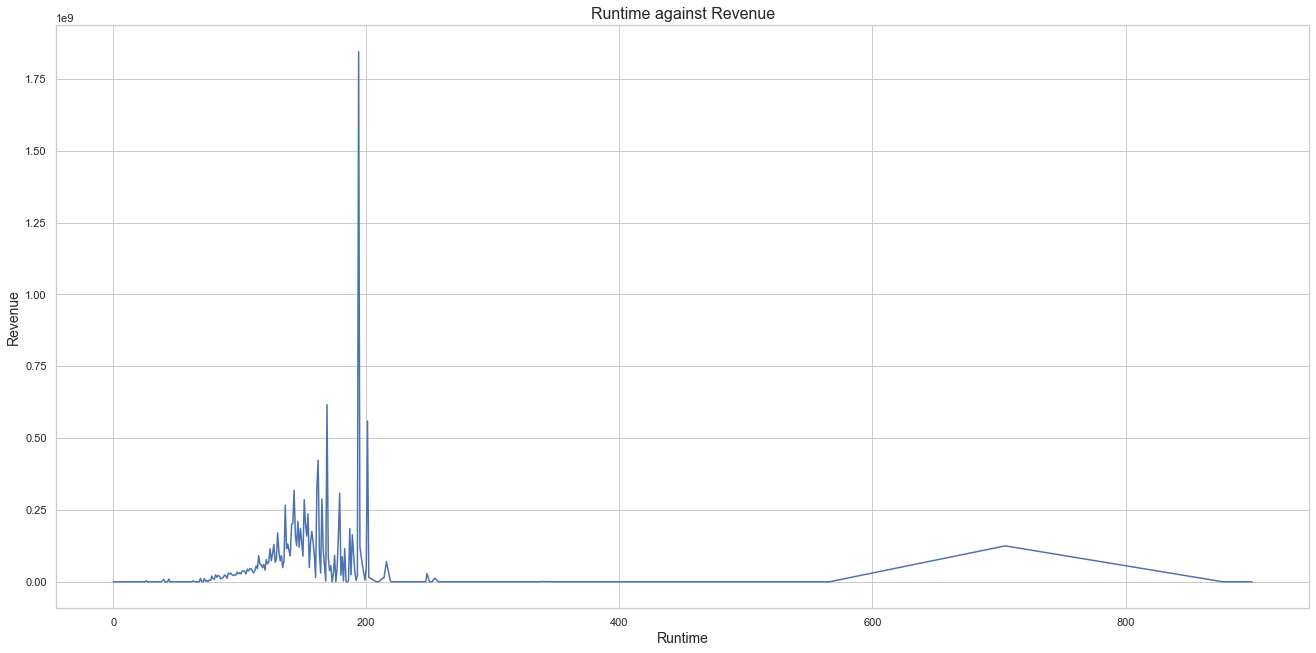

In [12]:

# Group data according to their runtime using Groupby function and observe high revenue runtimes
# Group data accprding to their runtime, find its mean and plot.
Mov_df.groupby('runtime').mean()['revenue'].plot()

#setup the title of the figure
plt.title("Runtime against Revenue",fontsize = 16)

#Axis labels of the plot.
plt.xlabel('Runtime',fontsize = 14)
plt.ylabel('Revenue',fontsize = 14)

#setup the figure size.
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("whitegrid")

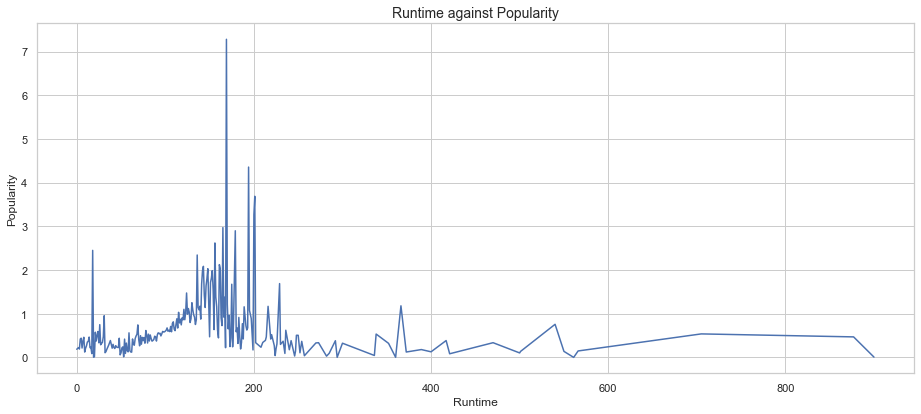

In [13]:
# Plotting for average runtimes and observing the most popular runtime

Mov_df.groupby('runtime').mean()['popularity'].plot()
#setup the title of the figure
plt.title("Runtime against Popularity",fontsize = 14)

#Axis labels of the plot.
plt.xlabel('Runtime',fontsize = 12)
plt.ylabel('Popularity',fontsize = 12)

#setup the figure size.
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("whitegrid")

#### From the plot, it can be seen that movies of 100-250 runtime are having higher revenues than other runtimes. The highest revenue is observed to be about 180.
> These also happen to be the most popular runtimes. 

> It can be infered that the popular runtimes give the highest revenues.

## Research Question 4: Which genres are most popular from year to year?

In [14]:
# Mapping all the rows of genres in a list.
genre_details = list(map(str,(Mov_df['genres'])))
genre = ['Adventure', 'Science Fiction', 'Fantasy', 'Crime', 'Western', 'Family','nan', 'Animation','War','Mystery','Romance','TV Movie','Action', 'Thriller','Comedy','Drama' , 'History', 'Music', 'Horror', 'Documentary', 'Foreign']

#Creating the numpy array of year and popularity which contain all the rows of release_year and popularity column.

year = np.array(Mov_df['release_year'])
popularity = np.array(Mov_df['popularity'])

# creatin a null datafrae with genre as indexes and years as columns

pop_df = pd.DataFrame(index = genre, columns = range(1960, 2016))
# change of the df from nan to zero
pop_df = pop_df.fillna(value = 0.0)

y = 0
for i in genre_details:
    splt_gen = list(map(str,i.split('|')))
    pop_df.loc[splt_gen, year[y]] = pop_df.loc[splt_gen, year[y]] + popularity[y]
    y+=1

# calculate the SD for accurate results.
def calc_SD(x):
    return (x-x.mean())/x.std(ddof=0)

pop_genre = calc_SD(pop_df)
pop_genre.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Adventure,0.753047,1.338265,1.996432,1.398764,0.550490,1.124313,0.951448,1.817532,1.534066,1.097634,...,0.608896,0.520337,0.755137,0.977663,1.034638,0.586530,0.732253,0.755530,1.174435,1.614759
Science Fiction,-0.467064,-0.361952,-0.640003,-0.646572,-0.667888,-0.869288,0.097082,-0.634089,1.452081,-0.710447,...,-0.285369,-0.305635,0.082456,0.679288,-0.104266,0.212188,0.189865,0.575138,0.902119,1.231957
Fantasy,-0.528631,-0.744050,-0.691929,-0.895883,-0.012691,-0.992961,-0.585750,-0.706100,-0.055098,-0.771756,...,0.064256,0.322410,0.008741,0.178378,0.153510,0.028812,0.081027,-0.182739,-0.108344,-0.320493
Crime,-0.607773,-0.111525,-0.192078,-0.020849,0.082887,-0.523188,-0.034184,0.517043,0.209143,0.593035,...,0.085715,0.302191,0.298300,-0.395319,-0.171136,-0.059809,0.092316,0.347388,-0.219402,0.027262
Western,0.705451,-0.588007,-0.266409,-0.863575,-1.009777,-0.527569,-0.028313,-0.775331,-0.824684,0.996730,...,-1.032584,-1.024569,-1.058297,-1.111565,-0.974311,-0.992158,-0.868553,-0.974491,-0.925887,-0.759302


In [15]:
def myLinePlot(ax,df,xVar,color=None):
    #plot
    ax.plot(df.columns, df.loc[xVar], label = xVar, color =color)
    
    #Adding labels
    ax.set_title(f'popularity average of {xVar} by year'.title(), fontsize = 12)
    ax.set_xlabel("Release year".title(), fontsize=10)
    ax.set_ylabel("Population".title(), fontsize=10)

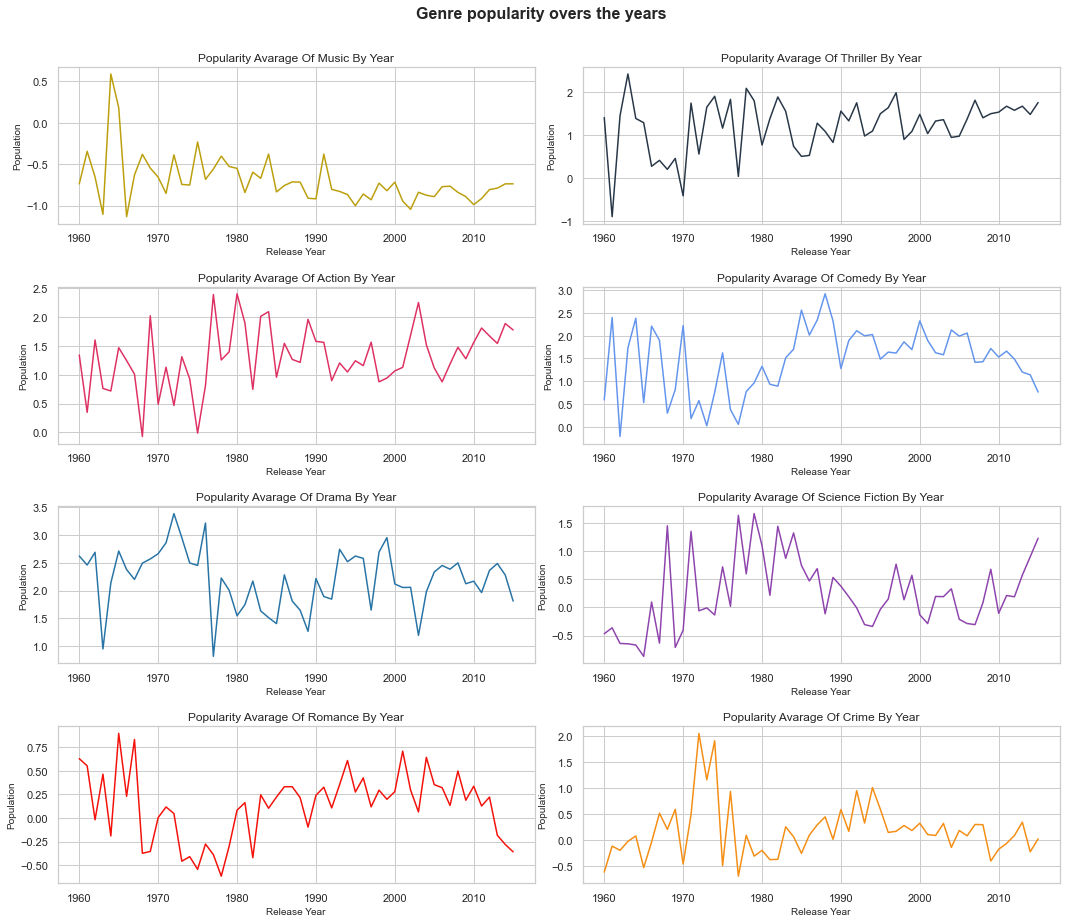

In [16]:
# Genre popularity over the years
# Plot title and size
fig = plt.figure(figsize=(16, 14))
fig.suptitle('Genre popularity overs the years', fontsize = 16, weight= "bold", y=0.94)

# genre subplots, 3 by 3
gs = fig.add_gridspec(4,2, hspace = 0.4, wspace = 0.1)
ax = gs.subplots(sharex =False, sharey=False)

# subplots
# genres and colors
genres_list = ['Music', 'Thriller', 'Action', 'Comedy', 'Drama', 'Science Fiction', 'Romance', 'Crime']
color_list = ["#BC9F0C", "#283747", "#DE3163", "#6495ED", "#2874A6", "#8E44AD", "#F3110A", "#F48E14"]

for ind, (genre, color) in enumerate(list(zip(genres_list, color_list))):
    myLinePlot(ax.flatten()[ind],pop_genre,genre,color=color)
    

#### Observations
> 1. Thriller and Action genres have generally been increasing in popularity
> 2. Music genre has seen its popularity generally decline over the years
> 3. Drama movies have generally maintained the popularity ratings more or less constant.

## Research Question 5: Which properties influence high movie profit?
> Plotting a correlation heatmap and scatter plots of 
> 1. profit vs popularity
> 2. profit vs budget
> 3. profit vs revenue
> 4. profit vs runtime

In [17]:
# create a correlation heatmap function
def correlation_map(c):
    corr = c.corr()
    x,ax = plt.subplots(figsize =(14 , 12))
    cmap = sns.diverging_palette(220 , 20 , as_cmap = True)
    x= sns.heatmap(corr,cmap=cmap,square=True, cbar_kws={'shrink' : .9}, ax=ax, annot=True, annot_kws = {'fontsize' : 12})

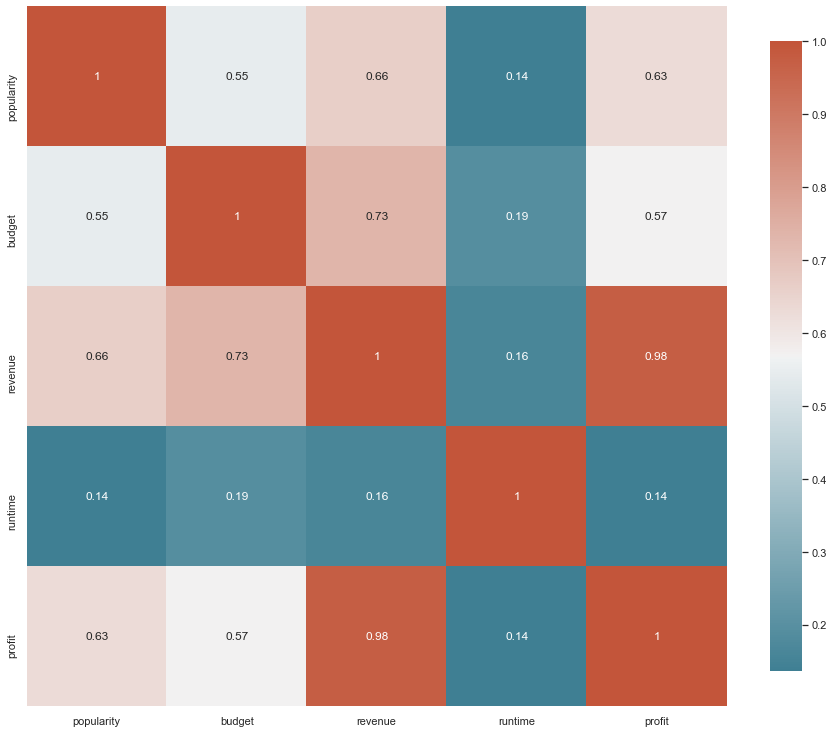

In [18]:
correlation_map(Mov_df[['popularity','budget','revenue','runtime','profit']])

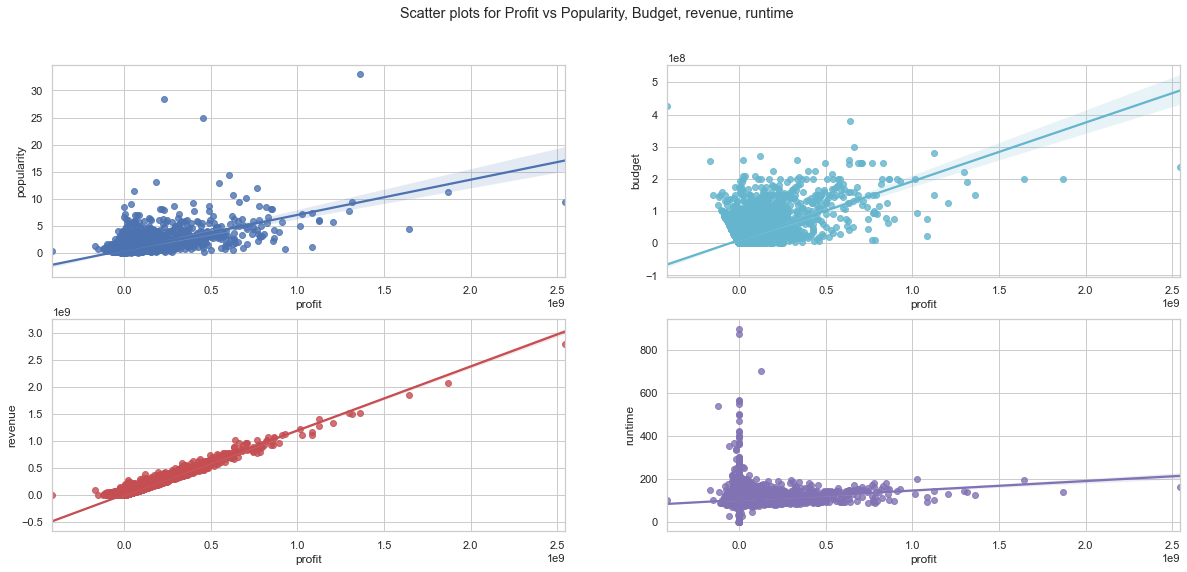

In [19]:
# Set the subplots 2 by 2 and the plot title.
fig, axes = plt.subplots(2,2, figsize=(18,8))
fig.suptitle("Scatter plots for Profit vs Popularity, Budget, revenue, runtime")

# Scatter plots for profit vs other properties.
sns.regplot(x=Mov_df['profit'], y=Mov_df['popularity'],color='b',ax=axes[0][0])
sns.regplot(x=Mov_df['profit'], y=Mov_df['budget'],color='c',ax=axes[0][1])
sns.regplot(x=Mov_df['profit'], y=Mov_df['revenue'],color='r',ax=axes[1][0])
sns.regplot(x=Mov_df['profit'], y=Mov_df['runtime'],color='m',ax=axes[1][1]);

### Observations
#### Plot 1: Popularity vs Profit.

Profit is seen to be increasing with popularity. It can be infered that when popularity is high the profits will be high.
 > correlation = 0.63
 
#### Plot 2: Budget vs Profit

Movies with higher budgets seem to be giving higher profits. It can be infered that higher investments may lead to higher profits.
 > Correlation = 0.57


#### Plot 3: Revenue Vs Profit
The profits are seen to be rising staedily with a rise in revenue. It can certainly be deduced that high revenues give high profits.
> correlation = 0.98

#### Plot 4: Runtime vs Profit
With a very low correlation of **0.14** it can be said that runtime isn't so much related to profits.

<a id='conclusions'></a>
## Conclusions

> 1. Generally the profitability of movies has been increasing over the years, with 1960-70 having the least profits realised.
> But having inflation adjustment reverses the trend, with highest profits realised between 1970 - 1980
> 2. Movie budgets had been increasing upto about 1999 where they took a downward turn.
> 3. It can be seen that movies of 100-250 runtime are more popular than other runtimes. Also happen to have the highest revenues.
> 4. Some genres have had their popularity ratings increasing over time(Action, Thriller), others somewhat holding constant(drama) while others decreasing over time(Music).
> 5. Popularity, revenue and budget seem to influnce positively the profits realised from the movies.

> There could be more research into the trends seen from the above. The characteristics of the most profitable movie genre, how does popularity influence profits.

### Limitation
> 1. Could not look at all the possible questions for the dataset, this due to inadequete time resource.
> 2. During data cleaning, splitting the '|' seperated data(For easier parsing) increased the computation time for the analysis



## References

> 1. https://matplotlib.org/stable/api/axes_api.html
> 2. https://seaborn.pydata.org/generated/seaborn.diverging_palette.html